In [1]:
import pysm3
import pysm3.units as u
import astropy.io.fits as fits
import reproject as rp

import healpy as hp
from fgbuster import (CMB, Dust, Synchrotron,
                      basic_comp_sep,
                      get_observation, get_noise_realization, get_instrument, get_sky)
from fgbuster.visualization import corner_norm


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Sky - pysm

In [28]:
nside = 512 #64

#Give pixel area given nside in square radians or square degrees.
pix_area_deg = hp.pixelfunc.nside2pixarea(nside, degrees=True) # degrees
pix_size_deg = np.sqrt(pix_area_deg) # degrees
pix_size = pix_size_deg *60 #arcmin
pix_size

print(f"With nside = {nside}, the pixel size is {pix_size} arcmin ({pix_size_deg} degrees)")

With nside = 512, the pixel size is 6.870972823634811 arcmin (0.11451621372724685 degrees)


In [29]:
# pysm sky
sky = pysm3.Sky(nside=nside, preset_strings=["d1", "s1"])

## Sky - fgbuster

Per fare la component separation alla fine mi serve un elemento di fgbuster del tipo (n_frequency, 3, n_pix), ma per trasformare le mappe da 1d a 2d per fare l'analisi mi serve un elemento di pysm del tipo (n_pix). Quindi creo il cielo con fgbuster, ma dallo strumento prendo solo una frequenza (in questo caso 100 GHz) in modo da avere un elemento (1, 3, n_pix), dove 3 rappresenta I, Q, U. In questo modo posso lavorare singolarmente su array 1d I, Q, U e alla fine posso riunirli facilmente in un elemento (1, 3, n_pix) per fare la component separation. 

In [30]:
instrument = get_instrument('LiteBIRD')

sky_fgb    = get_observation(instrument, sky , nside=nside,noise=False, unit='uK_CMB')
print(np.shape(sky_fgb))

(15, 3, 3145728)


In [31]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,40.0,37.42,26.46,70.5,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
1,50.0,33.46,23.66,58.5,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
2,60.0,21.31,15.07,51.1,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
3,68.0,16.87,11.93,47.1,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
4,78.0,12.07,8.53,43.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
5,89.0,11.30,7.99,41.5,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
6,100.0,6.56,4.64,37.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
7,119.0,4.58,3.24,33.6,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
8,140.0,4.79,3.39,30.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
9,166.0,5.57,3.94,28.9,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD


In [32]:
# seleziono solo alcune frequenze (8 su 15) altrimenti ci mette tantissimo
mappa40  = sky_fgb[0, :, :]
mappa68  = sky_fgb[3, :, :]
mappa78  = sky_fgb[4, :, :]
mappa100 = sky_fgb[6, :, :]
mappa140 = sky_fgb[8, :, :]
mappa195 = sky_fgb[10, :, :]
mappa280 = sky_fgb[12, :, :]
mappa402 = sky_fgb[14, :, :]


np.shape(mappa40)

(3, 3145728)

In [33]:
I_map40 = mappa40[0,:]
Q_map40 = mappa40[1,:]
U_map40 = mappa40[2,:]

I_map68 = mappa68[0,:]
Q_map68 = mappa68[1,:]
U_map68 = mappa68[2,:]

I_map78 = mappa78[0,:]
Q_map78 = mappa78[1,:]
U_map78 = mappa78[2,:]

I_map100 = mappa100[0,:]
Q_map100 = mappa100[1,:]
U_map100 = mappa100[2,:]

I_map140 = mappa140[0,:]
Q_map140 = mappa140[1,:]
U_map140 = mappa140[2,:]

I_map195 = mappa195[0,:]
Q_map195 = mappa195[1,:]
U_map195 = mappa195[2,:]

I_map280 = mappa280[0,:]
Q_map280 = mappa280[1,:]
U_map280 = mappa280[2,:]

I_map402 = mappa402[0,:]
Q_map402 = mappa402[1,:]
U_map402 = mappa402[2,:]

np.shape(I_map40)

(3145728,)

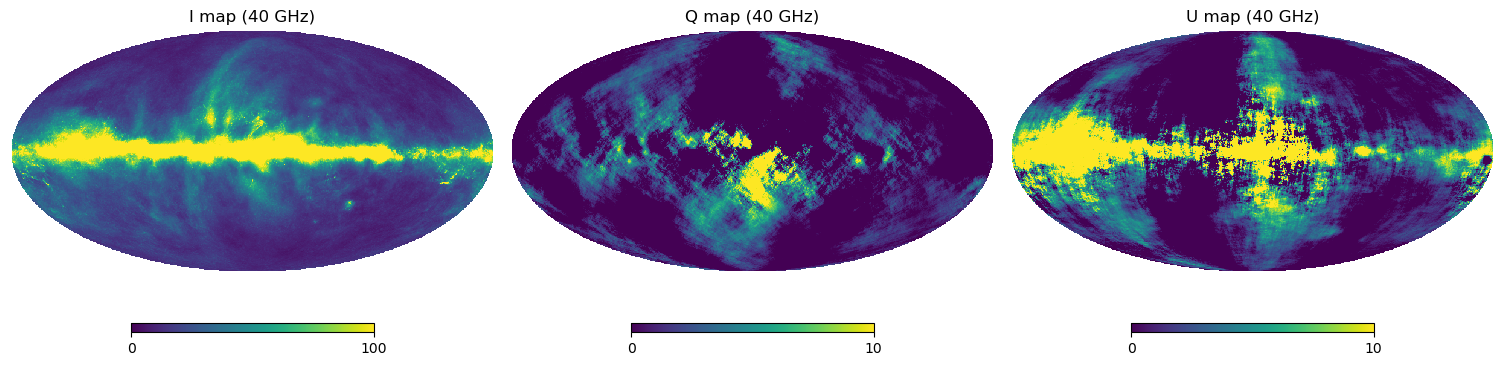

In [34]:
plt.figure(figsize=(15, 10))
hp.mollview(I_map40, min=0, max=1e2, title="I map (40 GHz)", sub=(1, 3, 1))
hp.mollview(U_map40, min=0, max=1e1, title="Q map (40 GHz)", sub=(1, 3, 2))
hp.mollview(Q_map40, min=0, max=1e1, title="U map (40 GHz)", sub=(1, 3, 3))

# Create patch 1D

In [38]:
def create_patch(RA1, RA2, dec1, dec2, nside, map):
    " cambiando il numero di nsdie bisognerà fare un primo test per definire il radius in vec in modo da avere una patch di area circa 10x10 deg e la lengh_patch in base alla len(patch_circle)"
    
    # coordinate della parte di cielo osservata da bicep
    theta1 = np.deg2rad(RA1)
    theta2 = np.deg2rad(RA2)

    phi1   = 0.5 * np.pi - np.deg2rad(dec1) 
    phi2   = 0.5 * np.pi - np.deg2rad(dec2)

    # trovo un punto in mezzo ai 4 vertici in modo da costruirci intorno una patch più piccola
    mid_theta = theta2 + (theta1-theta2)/2
    mid_phi   = phi2 + (phi1-phi2)/2


    # trasformo la lat e lon in indici
    index1 = hp.ang2pix(nside,phi1, theta1)
    index2 = hp.ang2pix(nside, phi2, theta1)
    index3 = hp.ang2pix(nside, phi2, theta2)
    index4 = hp.ang2pix(nside,phi1, theta2) 
    index_mid =  hp.ang2pix(nside,mid_phi, mid_theta) 
    
    
    # creo patch più piccola all'interno dei limiti RA e dec (è circolare e di un numero "sbagliato" di pixel per essere rappresentata con healpy)
    vec = hp.ang2vec(mid_phi, mid_theta)
    ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=np.radians(8))
    patch_circle = map[ipix_disc]
    print("Size patch circolare (num pixels): ", len(patch_circle))
    
    # all'interno di questa patch ne creo una un po' più piccola con un numero giusto di pixel
    lenght_patch = (35**2)*12 #(4**2)*12
    print("Size patch rettangolare (num pixels): ", lenght_patch)
    print("Area of the circular patch (deg^2) : " , (pix_size_deg**2) * lenght_patch)
    patch_rect   = patch_circle[int((len(patch_circle) - lenght_patch)/2): int((len(patch_circle) - lenght_patch)/2) + lenght_patch]
    
    return np.array(patch_rect)

In [39]:
RA1 = -60 
RA2 = 60
dec1 = -70
dec2 = -40

In [40]:
patch_test = create_patch(RA1, RA2, dec1, dec2, nside, I_map40)

Size patch circolare (num pixels):  15322
Size patch rettangolare (num pixels):  14700
Area of the circular patch (deg^2) :  192.77525913443986


In [41]:
patch1d_I40 = create_patch(RA1, RA2, dec1, dec2, nside, I_map40)
patch1d_Q40 = create_patch(RA1, RA2, dec1, dec2, nside, Q_map40)
patch1d_U40 = create_patch(RA1, RA2, dec1, dec2, nside, U_map40)

patch1d_I68 = create_patch(RA1, RA2, dec1, dec2, nside, I_map68)
patch1d_Q68 = create_patch(RA1, RA2, dec1, dec2, nside, Q_map68)
patch1d_U68 = create_patch(RA1, RA2, dec1, dec2, nside, U_map68)

patch1d_I78 = create_patch(RA1, RA2, dec1, dec2, nside, I_map78)
patch1d_Q78 = create_patch(RA1, RA2, dec1, dec2, nside, Q_map78)
patch1d_U78 = create_patch(RA1, RA2, dec1, dec2, nside, U_map78)

patch1d_I100 = create_patch(RA1, RA2, dec1, dec2, nside, I_map100)
patch1d_Q100 = create_patch(RA1, RA2, dec1, dec2, nside, Q_map100)
patch1d_U100 = create_patch(RA1, RA2, dec1, dec2, nside, U_map100)

patch1d_I140 = create_patch(RA1, RA2, dec1, dec2, nside, I_map140)
patch1d_Q140 = create_patch(RA1, RA2, dec1, dec2, nside, Q_map140)
patch1d_U140 = create_patch(RA1, RA2, dec1, dec2, nside, U_map140)

patch1d_I195 = create_patch(RA1, RA2, dec1, dec2, nside, I_map195)
patch1d_Q195 = create_patch(RA1, RA2, dec1, dec2, nside, Q_map195)
patch1d_U195 = create_patch(RA1, RA2, dec1, dec2, nside, U_map195)

patch1d_I280 = create_patch(RA1, RA2, dec1, dec2, nside, I_map280)
patch1d_Q280 = create_patch(RA1, RA2, dec1, dec2, nside, Q_map280)
patch1d_U280 = create_patch(RA1, RA2, dec1, dec2, nside, U_map280)

patch1d_I402 = create_patch(RA1, RA2, dec1, dec2, nside, I_map402)
patch1d_Q402 = create_patch(RA1, RA2, dec1, dec2, nside, Q_map402)
patch1d_U402 = create_patch(RA1, RA2, dec1, dec2, nside, U_map402)

Size patch circolare (num pixels):  15322
Size patch rettangolare (num pixels):  14700
Area of the circular patch (deg^2) :  192.77525913443986
Size patch circolare (num pixels):  15322
Size patch rettangolare (num pixels):  14700
Area of the circular patch (deg^2) :  192.77525913443986
Size patch circolare (num pixels):  15322
Size patch rettangolare (num pixels):  14700
Area of the circular patch (deg^2) :  192.77525913443986
Size patch circolare (num pixels):  15322
Size patch rettangolare (num pixels):  14700
Area of the circular patch (deg^2) :  192.77525913443986
Size patch circolare (num pixels):  15322
Size patch rettangolare (num pixels):  14700
Area of the circular patch (deg^2) :  192.77525913443986
Size patch circolare (num pixels):  15322
Size patch rettangolare (num pixels):  14700
Area of the circular patch (deg^2) :  192.77525913443986
Size patch circolare (num pixels):  15322
Size patch rettangolare (num pixels):  14700
Area of the circular patch (deg^2) :  192.7752591

In [42]:
fits.writeto("patch1d/patch1d_I40", patch1d_I40, overwrite=True)
fits.writeto("patch1d/patch1d_Q40", patch1d_Q40, overwrite=True)
fits.writeto("patch1d/patch1d_U40", patch1d_U40, overwrite=True)

fits.writeto("patch1d/patch1d_I68", patch1d_I68, overwrite=True)
fits.writeto("patch1d/patch1d_Q68", patch1d_Q68, overwrite=True)
fits.writeto("patch1d/patch1d_U68", patch1d_U68, overwrite=True)

fits.writeto("patch1d/patch1d_I78", patch1d_I78, overwrite=True)
fits.writeto("patch1d/patch1d_Q78", patch1d_Q78, overwrite=True)
fits.writeto("patch1d/patch1d_U78", patch1d_U78, overwrite=True)

fits.writeto("patch1d/patch1d_I100", patch1d_I100, overwrite=True)
fits.writeto("patch1d/patch1d_Q100", patch1d_Q100, overwrite=True)
fits.writeto("patch1d/patch1d_U100", patch1d_U100, overwrite=True)

fits.writeto("patch1d/patch1d_I140", patch1d_I140, overwrite=True)
fits.writeto("patch1d/patch1d_Q140", patch1d_Q140, overwrite=True)
fits.writeto("patch1d/patch1d_U140", patch1d_U140, overwrite=True)

fits.writeto("patch1d/patch1d_I195", patch1d_I195, overwrite=True)
fits.writeto("patch1d/patch1d_Q195", patch1d_Q195, overwrite=True)
fits.writeto("patch1d/patch1d_U195", patch1d_U195, overwrite=True)

fits.writeto("patch1d/patch1d_I280", patch1d_I280, overwrite=True)
fits.writeto("patch1d/patch1d_Q280", patch1d_Q280, overwrite=True)
fits.writeto("patch1d/patch1d_U280", patch1d_U280, overwrite=True)

fits.writeto("patch1d/patch1d_I402", patch1d_I402, overwrite=True)
fits.writeto("patch1d/patch1d_Q402", patch1d_Q402, overwrite=True)
fits.writeto("patch1d/patch1d_U402", patch1d_U402, overwrite=True)

### From galactic to celestial coordinates
https://github.com/aaroncnb/healpix_coordtrans_example/blob/master/hp_coordtrans_example.ipynb

## NB
Passando a mappe 2d la dimensione totale della mappa cambia. Prima era un array 1D lungo 192, adesso è una mappa 2D di cui posso scegliere la lunghezza delle x mentre le y sono x/2. 
Scelgo x tale che $192 = Area_{mappa} = x * (\frac{x}{2})$,

Da quello che ho capito è solo una questione di rappresentazione della mappa, ma non voglio che cambi la size dei pixel.

In [43]:
x = np.sqrt(len(patch1d_I40)*2) -1
int(x)

170

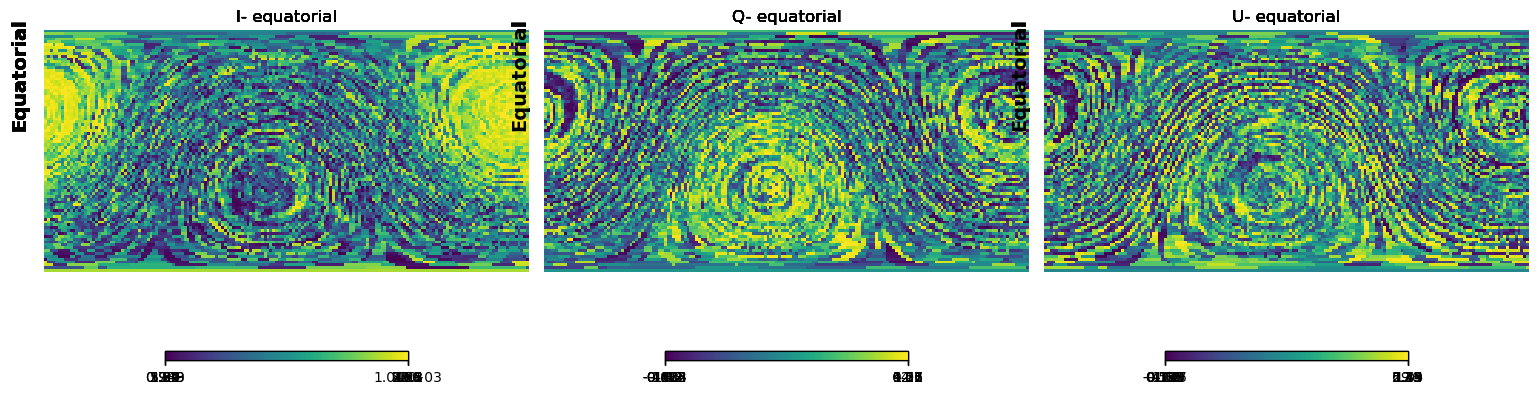

In [44]:
plt.figure(figsize=(15, 10))

patch2d_I40   = hp.cartview(patch1d_I40, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
patch2d_Q40   = hp.cartview(patch1d_Q40, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
patch2d_U40   = hp.cartview(patch1d_U40, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))

patch2d_I68   = hp.cartview(patch1d_I68, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
patch2d_Q68   = hp.cartview(patch1d_Q68, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
patch2d_U68   = hp.cartview(patch1d_U68, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))

patch2d_I78   = hp.cartview(patch1d_I78, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
patch2d_Q78   = hp.cartview(patch1d_Q78, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
patch2d_U78   = hp.cartview(patch1d_U78, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))

patch2d_I100  = hp.cartview(patch1d_I100, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
patch2d_Q100  = hp.cartview(patch1d_Q100, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
patch2d_U100  = hp.cartview(patch1d_U100, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))

patch2d_I140   = hp.cartview(patch1d_I140, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
patch2d_Q140   = hp.cartview(patch1d_Q140, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
patch2d_U140   = hp.cartview(patch1d_U140, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))

patch2d_I195   = hp.cartview(patch1d_I195, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
patch2d_Q195   = hp.cartview(patch1d_Q195, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
patch2d_U195   = hp.cartview(patch1d_U195, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))


patch2d_I280   = hp.cartview(patch1d_I280, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
patch2d_Q280   = hp.cartview(patch1d_Q280, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
patch2d_U280   = hp.cartview(patch1d_U280, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))


patch2d_I402   = hp.cartview(patch1d_I402, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
patch2d_Q402   = hp.cartview(patch1d_Q402, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
patch2d_U402   = hp.cartview(patch1d_U402, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))



In [45]:
np.shape(patch2d_I40)

(85, 170)

In [46]:
# quanto è grande un nuovo pixel? 
print(f"Un pixel della mappa 1D gande {len(patch1d_I40)} ha size = {pix_size} arcmin")

# proporzione (non so se serva, cambia poco) 
pix_size = (len(patch2d_I40)*len(patch2d_I40[0])*pix_size)/(len(patch1d_I40)) # proporzione
print(f"Un pixel della mappa 1D gande {len(patch2d_I40)*len(patch2d_I40[0])} ha size = {pix_size} arcmin")


Un pixel della mappa 1D gande 14700 ha size = 6.870972823634811 arcmin
Un pixel della mappa 1D gande 14450 ha size = 6.754119544321294 arcmin


In [47]:
patch2d_I40 = np.array(patch2d_I40)
patch2d_Q40 = np.array(patch2d_Q40)
patch2d_U40 = np.array(patch2d_U40)

patch2d_I68 = np.array(patch2d_I68)
patch2d_Q68 = np.array(patch2d_Q68)
patch2d_U68 = np.array(patch2d_U68)

patch2d_I78 = np.array(patch2d_I78)
patch2d_Q78 = np.array(patch2d_Q78)
patch2d_U78 = np.array(patch2d_U78)

patch2d_I100 = np.array(patch2d_I100)
patch2d_Q100 = np.array(patch2d_Q100)
patch2d_U100 = np.array(patch2d_U100)

patch2d_I140 = np.array(patch2d_I140)
patch2d_Q140 = np.array(patch2d_Q140)
patch2d_U140 = np.array(patch2d_U140)

patch2d_I195 = np.array(patch2d_I195)
patch2d_Q195 = np.array(patch2d_Q195)
patch2d_U195 = np.array(patch2d_U195)

patch2d_I280 = np.array(patch2d_I280)
patch2d_Q280 = np.array(patch2d_Q280)
patch2d_U280 = np.array(patch2d_U280)

patch2d_I402 = np.array(patch2d_I402)
patch2d_Q402 = np.array(patch2d_Q402)
patch2d_U402 = np.array(patch2d_U402)

In [48]:
print(np.shape(patch2d_U402))
print(len(patch2d_U402) * len(patch2d_U402[0]))

(85, 170)
14450


Le patch hanno cambiato numero di pixel, che non è più un numero rappresentabile con healpy. Le rimpicciolisco ancora un po' in modo che abbiano un numero giusto di pixel 

In [49]:
# le faccio di ...
nside_patch = 25 #3

N_full = 12 *( nside_patch**2)# number of pixels, full map
N_full

7500

In [50]:
# devo trovare un Nx e Ny tali che Nx*Ny = N_full
Nx = 100 #12
Ny = 75 #9

Nx * Ny

7500

In [51]:
pix_size_deg_new = pix_size / 60


X_width = Nx * pix_size_deg_new
Y_width = Ny * pix_size_deg_new


# color map
c_min, c_max     = -10, 10      


print(f"Patch con {Nx} x {Ny} pixels, ognuno di {pix_size} arcmin, per una dimensione totale di {X_width:.2f} x {Y_width:.2f} gradi")



Patch con 100 x 75 pixels, ognuno di 6.754119544321294 arcmin, per una dimensione totale di 11.26 x 8.44 gradi


In [52]:
np.shape(patch2d_I40)

(85, 170)

In [53]:
# creo le nuove patch grandi Nx x Ny 

starting_x = 0
starting_y = 0


patch2d_I40 =  np.array(patch2d_I40[starting_y:Ny, starting_x:Nx])
patch2d_Q40 =  np.array(patch2d_Q40[starting_y:Ny, starting_x:Nx])
patch2d_U40 =  np.array(patch2d_U40[starting_y:Ny, starting_x:Nx])

patch2d_I68 =  np.array(patch2d_I68[starting_y:Ny, starting_x:Nx])
patch2d_Q68 =  np.array(patch2d_Q68[starting_y:Ny, starting_x:Nx])
patch2d_U68 =  np.array(patch2d_U68[starting_y:Ny, starting_x:Nx])

patch2d_I78 =  np.array(patch2d_I78[starting_y:Ny, starting_x:Nx])
patch2d_Q78 =  np.array(patch2d_Q78[starting_y:Ny, starting_x:Nx])
patch2d_U78 =  np.array(patch2d_U78[starting_y:Ny, starting_x:Nx])

patch2d_I100 =  np.array(patch2d_I100[starting_y:Ny, starting_x:Nx])
patch2d_Q100 =  np.array(patch2d_Q100[starting_y:Ny, starting_x:Nx])
patch2d_U100 =  np.array(patch2d_U100[starting_y:Ny, starting_x:Nx])

patch2d_I140 =  np.array(patch2d_I140[starting_y:Ny, starting_x:Nx])
patch2d_Q140 =  np.array(patch2d_Q140[starting_y:Ny, starting_x:Nx])
patch2d_U140 =  np.array(patch2d_U140[starting_y:Ny, starting_x:Nx])

patch2d_I195 =  np.array(patch2d_I195[starting_y:Ny, starting_x:Nx])
patch2d_Q195 =  np.array(patch2d_Q195[starting_y:Ny, starting_x:Nx])
patch2d_U195 =  np.array(patch2d_U195[starting_y:Ny, starting_x:Nx])

patch2d_I280 =  np.array(patch2d_I280[starting_y:Ny, starting_x:Nx])
patch2d_Q280 =  np.array(patch2d_Q280[starting_y:Ny, starting_x:Nx])
patch2d_U280 =  np.array(patch2d_U280[starting_y:Ny, starting_x:Nx])

patch2d_I402 =  np.array(patch2d_I402[starting_y:Ny, starting_x:Nx])
patch2d_Q402 =  np.array(patch2d_Q402[starting_y:Ny, starting_x:Nx])
patch2d_U402 =  np.array(patch2d_U402[starting_y:Ny, starting_x:Nx])

### Save the 2d patches

In [54]:

fits.writeto("patch2d/patch2d_I40", patch2d_I40, overwrite=True)
fits.writeto("patch2d/patch2d_Q40", patch2d_Q40, overwrite=True)
fits.writeto("patch2d/patch2d_U40", patch2d_U40, overwrite=True)

fits.writeto("patch2d/patch2d_I68", patch2d_I68, overwrite=True)
fits.writeto("patch2d/patch2d_Q68", patch2d_Q68, overwrite=True)
fits.writeto("patch2d/patch2d_U68", patch2d_U68, overwrite=True)

fits.writeto("patch2d/patch2d_I78", patch2d_I78, overwrite=True)
fits.writeto("patch2d/patch2d_Q78", patch2d_Q78, overwrite=True)
fits.writeto("patch2d/patch2d_U78", patch2d_U78, overwrite=True)

fits.writeto("patch2d/patch2d_I100", patch2d_I100, overwrite=True)
fits.writeto("patch2d/patch2d_Q100", patch2d_Q100, overwrite=True)
fits.writeto("patch2d/patch2d_U100", patch2d_U100, overwrite=True)

fits.writeto("patch2d/patch2d_I140", patch2d_I140, overwrite=True)
fits.writeto("patch2d/patch2d_Q140", patch2d_Q140, overwrite=True)
fits.writeto("patch2d/patch2d_U140", patch2d_U140, overwrite=True)

fits.writeto("patch2d/patch2d_I195", patch2d_I195, overwrite=True)
fits.writeto("patch2d/patch2d_Q195", patch2d_Q195, overwrite=True)
fits.writeto("patch2d/patch2d_U195", patch2d_U195, overwrite=True)

fits.writeto("patch2d/patch2d_I280", patch2d_I280, overwrite=True)
fits.writeto("patch2d/patch2d_Q280", patch2d_Q280, overwrite=True)
fits.writeto("patch2d/patch2d_U280", patch2d_U280, overwrite=True)

fits.writeto("patch2d/patch2d_I402", patch2d_I402, overwrite=True)
fits.writeto("patch2d/patch2d_Q402", patch2d_Q402, overwrite=True)
fits.writeto("patch2d/patch2d_U402", patch2d_U402, overwrite=True)

In [55]:
np.shape(patch2d_U402)

(75, 100)